In [0]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
import os
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import prettytable as pt
np.random.seed(0)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Human Activity Recognition/HAR'
os.chdir(path)

In [0]:
!ls

grid_result.pkl		     t-sne_perp_20_iter_1000.png
HAR_EDA.ipynb		     t-sne_perp_2_iter_1000.png
HAR_LSTM.ipynb		     t-sne_perp_50_iter_1000.png
HAR_PREDICTION_MODELS.ipynb  t-sne_perp_5_iter_1000.png
t-sne_perp_10_iter_1000.png  UCI_HAR_Dataset


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
def _read_csv(filepath):
    return pd.read_csv(filepath, delim_whitespace=True, header=None)

In [0]:
# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        path= f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(path).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (
    # 7352 train/2947 test samples, 128 timesteps, 9 signals)
    # original shape of signals data is 9 * 7352 * 128 since
    # csv read results in 7352 * 128 size dataframe/matrix.
    # so we just swap the index value order.
    # 0 --> 2, 2--> 1, 1--> 0
    
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated
    /pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Plot function for weight distribution

def plot_weight_distribution(weights, hidden_layers=None):
    colors = ['b', 'r', 'g', 'y', 'm']
    fig = plt.figure()
    plt.title("Training Weights Distribution")
    
    for i in range(0, hidden_layers+1):
        layer_weights = weights[i*2].flatten().reshape(-1, 1)
        plt.subplot(1, hidden_layers+1, i+1)
        plt.title("Trained Weights")
        ax = sns.violinplot(y=layer_weights, color=colors[i%5])
        if i == hidden_layers:
            plt.xlabel("Out Layer")
        else:
            plt.xlabel("Layer {}".format(i+1))
    plt.show()

In [0]:
# Helpers for plotting losses
def plot_dynamic(x, vy, ty, ax, fig, colors=['b']):
    ax.plot(x, vy, 'r', label='Validation Loss')
    ax.plot(x, ty, 'b', label='Train Loss')
    plt.legend()
    plt.grid()
    fig.canvas.draw()

# Plotting Training/Validation Loss

def plot_loss(history, n_epochs):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Softmax Cross Entropy Loss")
    
    x = list(range(1, n_epochs+1))
    vy = history.history['val_loss']
    ty = history.history['loss']
    
    plot_dynamic(x, vy, ty, ax, fig)

In [0]:
# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [0]:
def print_results(data):
    result = pt.PrettyTable(hrules=pt.ALL, vrules=pt.ALL, padding_width=5)
    result.field_names = list(data.columns)
    for i in range(0, data.shape[0]):
        result.add_row(data.iloc[i])
    print(result)

In [0]:
results = pd.DataFrame(columns=['Model', 'Hidden Layers', 
                                'Train Loss','Train Accuracy(%)', 
                                'Test Loss', 'Test Accuracy(%)'])

In [0]:
gridcv_result = pd.DataFrame(columns=['Parameter', 'Parameter_Values', 
                                    'Best Param Value', 'Best Score', 'Loss'])

In [0]:
hyperparam_used = pd.DataFrame(columns=['Model','LSTM units', 'Epochs', 
                                        'Batch Size', 'Optimizer', 
                                        'Dropout', 'KernelInit'])

In [0]:
# Building an LSTM model

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers.normalization import BatchNormalization

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps, input_dim, len(X_train))

128 9 7352


In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 32)                5376      
_________________________________________________________________
dropout_50 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs, verbose=0)

In [0]:
print('Training Accuracy : {0:.2f}%'.format(history.history['acc'][-1]*100))

print('Training Loss : {0:.6f}'.format(history.history['loss'][-2]))

Training Accuracy : 94.63%
Training Loss : 0.155331


In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (score[1]*100))
print("Test Loss: %.6f" % (score[0]))

Test Accuracy: 90.46%
Test Loss: 0.354653


In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   1   
SITTING                  0      400        89        0                   1   
STANDING                 0       86       446        0                   0   
WALKING                  0        0         1      460                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 390   
WALKING_UPSTAIRS         0        0         0       11                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            26  
SITTING                            1  
STANDING                           0  
WALKING                           33  
WALKING_DOWNSTAIRS                30  
WALKING_UPSTAIRS                 460  


In [0]:
# Saving the result 
results.loc[results.shape[0]] = ['Initial Model', '2', '0.155331', 
                                 '94.63', '0.354653', '90.46']

In [0]:
def lstm_model(lstm_units=100, dropout_rate=0.5):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(timesteps, input_dim)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                 metrics=['accuracy'])
    return model

In [0]:
model = KerasClassifier(build_fn=lstm_model, epochs=epochs, 
                        batch_size=batch_size, verbose=0)

In [0]:
# lstm units will be calculated based on Nh = Ns / (c * (Ni + No))
# c is a scaling factor that typically lies between range of [2-10]
# Ni = 9, No = 6, Ns = 7352, Ns / 15 = 490.0
n_hidden = [int(490.0/scale) for scale in range(2,9)]
print(n_hidden)

[245, 163, 122, 98, 81, 70, 61]


In [0]:
# Since gridsearch is time consuming, we will use fewer n_hidden
# configurations which are close to the powers of 2. Also we will
# work with cv=2.

n_hidden = [128, 100, 80, 70, 64]

In [0]:
# We will pass n_hidden as param_grid to gridsearch

param_grid = dict(lstm_units=n_hidden)

In [0]:
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)

In [0]:
grid_result = grid_model.fit(X_train, Y_train)

In [0]:
pkl.dump(grid_result, open("grid_result.pkl", "wb")) 

In [0]:
grid_result = pkl.load(open("grid_result.pkl", "rb"))

In [0]:
# summarize results
print("Best Accuracy: %f using %s\n" % (grid_result.best_score_, 
                             grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("\nAccuracy  (Loss)    with: # LSTM units")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Accuracy: 0.877720 using {'lstm_units': 100}


Accuracy  (Loss)    with: # LSTM units
0.742791 (0.090452) with: {'lstm_units': 128}
0.877720 (0.000680) with: {'lstm_units': 100}
0.504081 (0.151251) with: {'lstm_units': 80}
0.843716 (0.010473) with: {'lstm_units': 70}
0.676551 (0.086507) with: {'lstm_units': 64}


In [0]:
# Saving the grid result 
gridcv_result.loc[gridcv_result.shape[0]] = ['# LSTM units', 
                                             '64, 70, 80, 100, 128', 
                                             '100', '87.77', '0.000680']

In [0]:
# Since we obtained the best score with 100 LSTM units in LSTM
# layer, we will try to fine tune the other parameters such as 
# dropout to see if we can improve the accuracy while keeping
# units @ 100.
# We were using a dropout of 0.5 in the earlier model, so we will
# try to use [0.5, 0.6, 0.7, 0.8] since we have very less data and
# with 100 LSTM units model can overfit easily.

param_grid = dict(dropout_rate=[0.5, 0.6, 0.7, 0.8])
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)

In [0]:
grid_result = grid_model.fit(X_train, Y_train)

In [0]:
# summarize results
print("Best Accuracy: %f using %s\n" % (grid_result.best_score_, 
                             grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("\nAccuracy  (Loss)    with: # Dropout Rate")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Accuracy: 0.866295 using {'dropout_rate': 0.6}


Accuracy  (Loss)    with: # Dropout Rate
0.802639 (0.064880) with: {'dropout_rate': 0.5}
0.866295 (0.017546) with: {'dropout_rate': 0.6}
0.746328 (0.101061) with: {'dropout_rate': 0.7}
0.605005 (0.016866) with: {'dropout_rate': 0.8}


In [0]:
# Saving the grid result 
gridcv_result.loc[gridcv_result.shape[0]] = ['Dropout Rate', 
                                             '0.5, 0.6, 0.7, 0.8', 
                                             '0.6', '86.62', '0.017546']

In [0]:
def lstm_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(100, input_shape=(timesteps, input_dim)))
    model.add(Dropout(0.6))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                 metrics=['accuracy'])
    return model

In [0]:
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [20, 40, 60]
param_grid = dict(batch_size=batch_size, epochs=epochs)

In [0]:
model = KerasClassifier(build_fn=lstm_model, verbose=0)

In [0]:
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid_model.fit(X_train, Y_train)

In [0]:
# summarize results
print("Best Accuracy: %f using %s\n" % (grid_result.best_score_, 
                             grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("\nAccuracy  (Loss)    with:\tBatch_Size \tEpochs")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Accuracy: 0.864255 using {'batch_size': 40, 'epochs': 60}


Accuracy  (Loss)    with:	Batch_Size 	Epochs
0.552639 (0.079026) with: {'batch_size': 10, 'epochs': 20}
0.750136 (0.105958) with: {'batch_size': 10, 'epochs': 40}
0.856638 (0.025027) with: {'batch_size': 10, 'epochs': 60}
0.440560 (0.084467) with: {'batch_size': 20, 'epochs': 20}
0.696545 (0.195729) with: {'batch_size': 20, 'epochs': 40}
0.677231 (0.098341) with: {'batch_size': 20, 'epochs': 60}
0.447497 (0.034004) with: {'batch_size': 40, 'epochs': 20}
0.638194 (0.015778) with: {'batch_size': 40, 'epochs': 40}
0.864255 (0.026931) with: {'batch_size': 40, 'epochs': 60}
0.342764 (0.003808) with: {'batch_size': 60, 'epochs': 20}
0.569233 (0.120647) with: {'batch_size': 60, 'epochs': 40}
0.610446 (0.018226) with: {'batch_size': 60, 'epochs': 60}
0.403700 (0.041077) with: {'batch_size': 80, 'epochs': 20}
0.499048 (0.132617) with: {'batch_size': 80, 'epochs': 40}
0.584195 (0.040125) with: {'batch_size': 80, 'epochs': 60}
0.477

In [0]:
# Saving the grid result 
gridcv_result.loc[gridcv_result.shape[0]] = ['Batch Size / Epochs', 
                 'Batch size : 10, 20, 40, 60, 80, 100 \n Epochs : 20, 40, 60', 
                 'Batch size : 40 \n Epochs : 60', '86.42', '0.017546']

In [0]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
param_grid = dict(optimizer=optimizer)

In [0]:
model = KerasClassifier(build_fn=lstm_model, verbose=0, 
                        batch_size=40, epochs=60)

In [0]:
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid_model.fit(X_train, Y_train)

In [0]:
# summarize results
print("Best Accuracy: %f using %s\n" % (grid_result.best_score_, 
                             grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("\nAccuracy  (Loss)    with:\t Optimizer")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Accuracy: 0.888874 using {'optimizer': 'RMSprop'}


Accuracy  (Loss)    with:	 Optimizer
0.461507 (0.035773) with: {'optimizer': 'SGD'}
0.888874 (0.004489) with: {'optimizer': 'RMSprop'}
0.764554 (0.004489) with: {'optimizer': 'Adagrad'}
0.875272 (0.019995) with: {'optimizer': 'Adadelta'}
0.734086 (0.022443) with: {'optimizer': 'Adam'}


In [0]:
# Saving the grid result 
gridcv_result.loc[gridcv_result.shape[0]] = ['Optimizer', 
                 'SGD, RMSprop, Adagrad, Adadelta, Adam', 
                 'RMSprop', '88.89', '.004489']

In [0]:
# Since we are not able to better 90% accuracy that we achieved with
# n_hidden = 32 units , let's try to run the model for smaller
# values of LSTM units.

def lstm_model(lstm_units=32):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(timesteps, input_dim)))
    model.add(Dropout(0.6))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', 
                 metrics=['accuracy'])
    return model

In [0]:
lstm_units = [8, 16, 24, 32]
param_grid = dict(lstm_units=lstm_units)

In [0]:
model = KerasClassifier(build_fn=lstm_model, verbose=0, 
                        batch_size=40, epochs=60)

In [0]:
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid_model.fit(X_train, Y_train)

In [0]:
# summarize results
print("Best Accuracy: %f using %s\n" % (grid_result.best_score_, 
                             grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("\nAccuracy  (Loss)    with:\t LSTM Units")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Accuracy: 0.848613 using {'lstm_units': 32}


Accuracy  (Loss)    with:	 LSTM Units
0.625000 (0.019723) with: {'lstm_units': 8}
0.797062 (0.071817) with: {'lstm_units': 16}
0.757889 (0.087595) with: {'lstm_units': 24}
0.848613 (0.028156) with: {'lstm_units': 32}


In [0]:
from keras.callbacks import ModelCheckpoint

# checkpoint
filepath="weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(100, input_shape=(timesteps, input_dim), 
               kernel_initializer='he_normal'))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='RMSprop', 
                 metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=40,
          validation_data=(X_test, Y_test),
          epochs=40, callbacks=callbacks_list, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 100)               44000     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 6)                 606       
Total params: 44,606
Trainable params: 44,606
Non-trainable params: 0
_________________________________________________________________


In [0]:
# load weights
model.load_weights("weights.best.hdf5")
weights = model.get_weights()

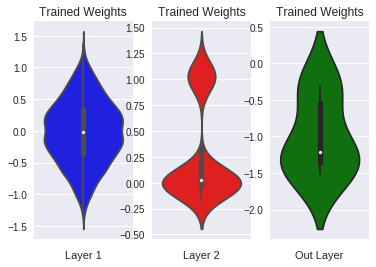

In [0]:
plot_weight_distribution(weights, hidden_layers=2)

In [0]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Training Accuracy : {0:.2f}%'.format(score[1]*100))
print('Training Loss : {0:.6f}'.format(score[0]))


score = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (score[1]*100))
print("Test Loss: %.6f" % (score[0]))

Training Accuracy : 95.89%
Training Loss : 0.100544
Test Accuracy: 92.40%
Test Loss: 0.377630


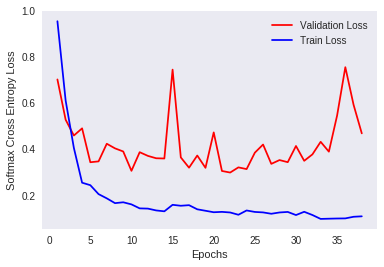

In [0]:
plot_loss(history, n_epochs=40)

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        25        0                   0   
SITTING                  5      411        74        0                   0   
STANDING                 0       69       463        0                   0   
WALKING                  0        2         1      471                  22   
WALKING_DOWNSTAIRS       0        2         0        4                 413   
WALKING_UPSTAIRS         0        5         0        7                   4   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             2  
SITTING                            1  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 455  


In [0]:
# Saving the result 
results.loc[results.shape[0]] = ['Tuned Model', '2', '0.100544', 
                                 '95.89', '0.377630', '92.40']

In [0]:
# Saving the grid result 
hyperparam_used.loc[hyperparam_used.shape[0]] = ['Initial Model','32', '30', 
                                                 '16', 
                                                 'RMSprop', 
                                                 '0.5', 'glorot-uniform']

hyperparam_used.loc[hyperparam_used.shape[0]] = ['Tuned Model', '100', '40', 
                                                 '40', 'RMSprop', 
                                                 '0.6', 'he-normal']

# Results :

In [0]:
print("HyperParameterTuning results on Various Parameters : \n")
print_results(gridcv_result)

print("\n\nParameters for tuned model were chosen based on results above.\n ")
print("\n\nParameter Comparison :\n")

print("Initial Model vs Tuned Model \n")

print_results(hyperparam_used)
print("\n\n")

print("Final Results : \n")
print_results(results)

HyperParameterTuning results on Various Parameters : 

+-----------------------------+-----------------------------------------------+--------------------------+--------------------+------------------+
|          Parameter          |                Parameter_Values               |     Best Param Value     |     Best Score     |       Loss       |
+-----------------------------+-----------------------------------------------+--------------------------+--------------------+------------------+
|         # LSTM units        |              64, 70, 80, 100, 128             |           100            |       87.77        |     0.000680     |
+-----------------------------+-----------------------------------------------+--------------------------+--------------------+------------------+
|         Dropout Rate        |               0.5, 0.6, 0.7, 0.8              |           0.6            |       86.62        |     0.017546     |
+-----------------------------+--------------------------------

# Observations :

Below mentioned approach was followed to train an LSTM network on Human Activity Recognition Dataset.

We started off with an initial model which had the following architecture.

1. We defined a sequential model by using Sequential() function since data flows sequentially in the network from input layer to output layer. Network had 1 LSTM layer followed by Dropout layer and a Dense softmax layer since this is a multiclass classification problem. model.add() function was used to add various layers to the network. We fixed the network parameters such as epochs to 30, batch size to 16, number of LSTM units to 32, optimizer to RMSprop, dropout to 0.5 and kernel initializer was not explicitly set so keras by default used glorot-uniform for weight initialization in LSTM layer.

2. This initial model achieved an accuracy of 90.46% with a test loss of 0.3546.

**Objective : ** 

  Our objective was to improve on the accuracy achieved by the initial model.

**Steps taken to tune the hyperparameters of the initial model :**

1. We initially tried various values for number of LSTM units in the LSTM layer. The number of LSTM units ranged from 8 to 128.  To get a sense of the values to try we used the formula Nh = Ns / (c * (Ni + No))
and c is a scaling factor that typically lies between range of [2-10]. Nh is the number of units. Ns is the number of data points. Ni is number of inputs and No is number of outputs. This gave us a sense of what values can be tried for LSTM units. We didn't run the model with exact values but took nearby values, some of which were powers of 2 for runtime performance reasons. Gridsearch was used to perform hyperparameter tuning. From the gridsearch results we observed that 100 LSTM units gave the best accuracy.


2. We fixed the LSTM units to 100 and tried to tune the dropout rate. Since the number of training samples is less, network can easily overfit to training data with higher number of LSTM units. So we tried higher values of dropout rate ranging from 0.5 to 0.8. From the gridsearch results we observed that dropout rate of 0.6 gave the best accuracy.


3. We fixed the LSTM units to 100 and dropout rate to 0.6 and tried to tune the batch size and epochs. Given the fact that LSTM's are pretty sensitive to batch size and epochs, we tried various combinations of batch size and epochs. From the gridsearch results we observed that batch size of 40 and epochs value of 60 gave the best accuracy.


4. Now we fixed the LSTM units to 100, dropout rate to 0.6, batch size to 40, epochs to 60 and tried to tune the optimizer. It was observed that of various optimizers such as Adam, RMSprop, AdaDelta, SGD and AdaGrad, RMSprop produced the best results. So optimizer was fixed to RMSprop.


5. Also it was observed that weight intitialization performed using he-normal performed much better than the default golorot-uniform initialization.


6. After tuning the values of various hyperparameters, we built a new model which had the following architecture.

Input 

          --> LSTM layer (100 LSTM units, he-normal weight initialization) 

          --> Dropout Layer (dropout rate = 0.6)
          
          --> Output Softmax Layer (sigmoid activation)
          
Output


Categorical cross entropy was used as a loss metric and Accuracy was used as a performance metric.
RMSprop was used as optimizer for adaptive learning rate.

We used keras call back function ModelCheckpoint to save the learnt weights for the final model to keep track of degrading model performance with increasing epochs after a point.

With tuned parameters we observed an accuracy of 92.40% which is a fair improvement over 90.46% that out initial model yielded.

Confusion matrix for both initial model and tuned model indicate that initial model was confused between sitting and standing as well as made a lot of errors when it predicted the class to be walking upstairs.
Our tuned model greatly reduced the confusion regarding walking upstairs and also reduced the confusion between sitting and standing.


Weight plot of final trained model weight seem fairly contained in a small range.


**Conclusion : **

Accuracy of tuned model was 92.40% and weight initialization as well as optimizer choice greatly affected the performance of the model.